# Sports Action Recognition Using CNN-RNN Architecture with Transfer Learning on `UCF101 10 Sports actions`

## Dependencies

In [12]:
!pip install kagglehub --quiet

In [13]:
import os
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix

import imageio
import cv2
from IPython.display import Image

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import top_k_categorical_accuracy

import kagglehub

## Dataset Loading

Download latest version of the ucf101-action-recognition dataset from Kaggle

In [14]:
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

In [15]:
print("Path to dataset files: \n", path)
print("\nFiles in dataset directory:\n", os.listdir(path))

Path to dataset files: 
 /Users/mzitoh/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4

Files in dataset directory:
 ['test', 'val.csv', 'test.csv', 'train', 'train.csv', 'val']


**Class Definition**

In [16]:
sports_actions = [
    "SkyDiving",
    "Biking",
    "HorseRace",
    "Surfing",
    "TennisSwing",
    "Punch",
    "Basketball",
    "JumpRope",
    "Archery",
    "Skiing",
]

Utility to transform video paths

In [17]:
def load_dataset(dataset_type):
    dataset_path = os.path.join(path, f"{dataset_type}.csv")
    dataset = pd.read_csv(dataset_path)

    # Filter dataset to only include the specified sports actions
    filtered_dataset = dataset[dataset["label"].isin(sports_actions)]

    return pd.DataFrame(
        {
            "label": filtered_dataset["label"],
            "video_name": filtered_dataset["clip_name"],
            "rel_path": filtered_dataset["clip_path"],
            "video_path": filtered_dataset["clip_path"].apply(lambda x: f"{path}{x}"),
        }
    )

Load the train and test datasets

In [18]:
train_df = load_dataset("train")
val_df = load_dataset("val")
test_df = load_dataset("test")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for validation: {len(val_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 1128
Total videos for validation: 189
Total videos for testing: 192


In [19]:
print("Number of unique classes in training set: ", len(train_df["label"].unique()))
print("Number of unique classes in validation set: ", len(val_df["label"].unique()))
print("Number of unique classes in test set: ", len(test_df["label"].unique()))

print("\nLabels: \n", train_df["label"].unique())

Number of unique classes in training set:  10
Number of unique classes in validation set:  10
Number of unique classes in test set:  10

Labels: 
 ['SkyDiving' 'TennisSwing' 'Skiing' 'Punch' 'Archery' 'JumpRope'
 'Basketball' 'Biking' 'HorseRace' 'Surfing']


In [20]:
train_df.sample(10)

,label,video_name,rel_path,video_path
157,SkyDiving,v_SkyDiving_g13_c01,/train/SkyDiving/v_SkyDiving_g13_c01.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
5215,Basketball,v_BasketballDunk_g02_c02,/train/Basketball/v_BasketballDunk_g02_c02.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
867,TennisSwing,v_TennisSwing_g03_c01,/train/TennisSwing/v_TennisSwing_g03_c01.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
9014,HorseRace,v_HorseRace_g02_c03,/train/HorseRace/v_HorseRace_g02_c03.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
5223,Basketball,v_BasketballDunk_g07_c05,/train/Basketball/v_BasketballDunk_g07_c05.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
1845,Skiing,v_Skiing_g24_c02,/train/Skiing/v_Skiing_g24_c02.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
819,TennisSwing,v_TennisSwing_g20_c02,/train/TennisSwing/v_TennisSwing_g20_c02.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
2868,Punch,v_Punch_g07_c04,/train/Punch/v_Punch_g07_c04.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
835,TennisSwing,v_TennisSwing_g19_c05,/train/TennisSwing/v_TennisSwing_g19_c05.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...
5133,Basketball,v_Basketball_g18_c04,/train/Basketball/v_Basketball_g18_c04.avi,/Users/mzitoh/.cache/kagglehub/datasets/matthe...


## Configs and Hyperparameters

In [209]:
MODEL_NAME = "cnn_rnn_ucf101_10c_tl"

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 140
LEARNING_RATE = 1e-4

MAX_SEQ_LENGTH = 20 # TODO: Check the distribution of the sequence lengths
NUM_FEATURES = 2048

Set path for model saving and retrieval

In [22]:
base_dir = "../../models"
pattern = re.compile(rf"{MODEL_NAME}_v(\d+)\.keras")

existing_versions = [
    int(pattern.search(f).group(1)) 
    for f in os.listdir(base_dir) if pattern.search(f)
]
version = max(existing_versions, default=0) + 1
MODEL_PATH = os.path.join(base_dir, f"{MODEL_NAME}_v{version}.keras")

print(f"Model will be saved to: '{MODEL_PATH}'")

Model will be saved to: '../../models/cnn_rnn_ucf101_10c_tl_v1.keras'


## Video Data Preprocessing

#### Review video category distribution

Combined average number of videos per class:
             Train  Validation  Test  Average
label                                        
Archery        108          18    19       48
Basketball     198          33    34       88
Biking         100          17    17       45
HorseRace       93          15    16       41
JumpRope       108          18    18       48
Punch          120          20    20       53
Skiing         101          17    17       45
SkyDiving       82          14    14       37
Surfing         94          16    16       42
TennisSwing    124          21    21       55


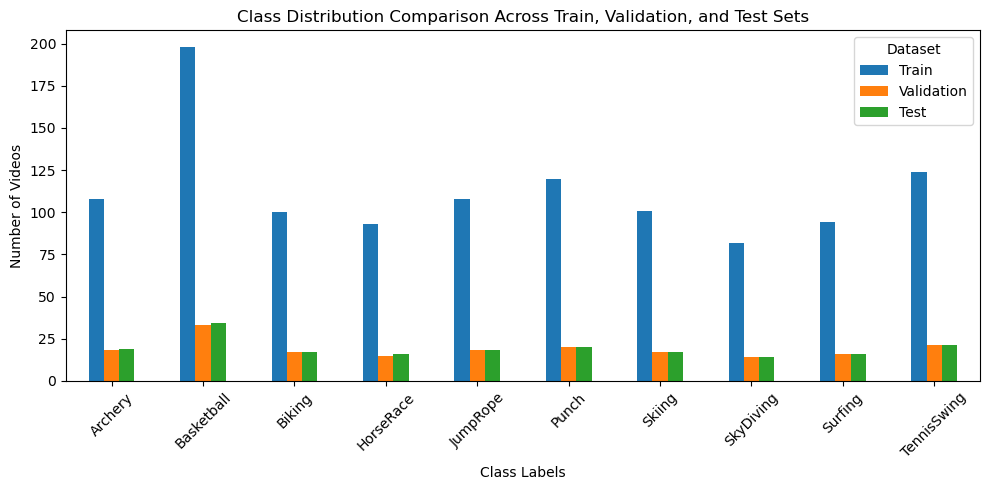

In [23]:
def review_class_distribution(dataset, dataset_name):
    class_counts = dataset["label"].value_counts()
    return class_counts

# Get class distributions for each dataset
train_class_counts = review_class_distribution(train_df, "Train")
val_class_counts = review_class_distribution(val_df, "Validation")
test_class_counts = review_class_distribution(test_df, "Test")

# Create DataFrame for distribution and calculate average
distribution_df = pd.DataFrame({
    "Train": train_class_counts,
    "Validation": val_class_counts,
    "Test": test_class_counts
}).fillna(0)

distribution_df["Average"] = distribution_df.mean(axis=1).round().astype(int)
print("Combined average number of videos per class:")
print(distribution_df)

# Plot the distribution
plot_distribution_df = distribution_df.drop(columns="Average")
plot_distribution_df.plot(kind="bar", figsize=(10, 5))
plt.title("Class Distribution Comparison Across Train, Validation, and Test Sets")
plt.xlabel("Class Labels")
plt.ylabel("Number of Videos")
plt.legend(title="Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Review Video frame distribution 

Count the number of frames for each video

In [24]:
def count_frames_per_video(video_paths):
    frame_counts = []

    for video_path in video_paths: 
        cap = cv2.VideoCapture(video_path)
        count = 0
        
        if len(frame_counts) > 10:
            break
        
        while cap.isOpened():
            ret, _ = cap.read()
            if not ret:
                break
            count += 1
        cap.release()
        frame_counts.append(count)

    return frame_counts

In [25]:
def visualize_frame_distribution(frame_counts):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=frame_counts)
    plt.title("Violin Plot of Frame Counts per Video")
    plt.xlabel("Number of Frames")
    plt.xlabel("Number of Frames")
    plt.show()

In [26]:
frame_counts = count_frames_per_video(train_df["video_path"].values)

Standard deviation of the frame counts

In [27]:
np.std(frame_counts)

36.023867203070566

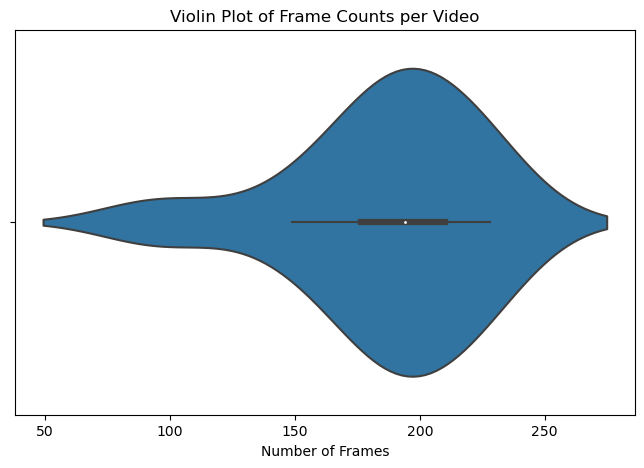

In [28]:
visualize_frame_distribution(frame_counts)

### Video preprocessing utilities

 Function to resize the video frames to a square shape without distorting their content

In [29]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]  # Get the height (y) and width (x) of the image
    min_dim = min(y, x)       # Find the smallest dimension (either height or width)
    start_x = (x // 2) - (min_dim // 2)  # Calculate the horizontal starting point for the crop
    start_y = (y // 2) - (min_dim // 2)  # Calculate the vertical starting point for the crop
    
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]  # Return the cropped square

Crop,resize, and reorder color channels

In [30]:
def load_and_preprocess_video(video_path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame) # Crop center square
            frame = cv2.resize(frame, resize) # Resize the image (In this case to 224x224)
            frame = frame[:, :, [2, 1, 0]] # Reorder the color channels from OpenCV BGR to RGB
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
   
    return np.array(frames)

### Feature Extraction

Using a pre-trained network to extract meaningful features from the extracted frames, the InceptionV3 model pretrained on ImageNet-1k dataset

In [31]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [32]:
feature_extractor = build_feature_extractor()

Encode the class labels as integers using the Keras StringLookup layer

In [33]:
np.unique(train_df["label"])

array(['Archery', 'Basketball', 'Biking', 'HorseRace', 'JumpRope',
       'Punch', 'Skiing', 'SkyDiving', 'Surfing', 'TennisSwing'],
      dtype=object)

In [34]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=sports_actions)

class_vocab = label_processor.get_vocabulary()

print(f"Vocabulary: {class_vocab}")
print(f"Number of classes: {len(class_vocab)}")

Vocabulary: ['SkyDiving', 'Biking', 'HorseRace', 'Surfing', 'TennisSwing', 'Punch', 'Basketball', 'JumpRope', 'Archery', 'Skiing']
Number of classes: 10


label_processorExtract frame_features, frame_masks and labels
- `frame_features` will contain extracted features per frame
- `frame_masks` will contain booleans denoting if a timestep/frame is padded or not

Helper function to create masks and features for a single video

In [35]:
def create_video_mask_and_features(frames):
    frames = frames[None, ...]  # Add batch dimension
    video_length = min(MAX_SEQ_LENGTH, frames.shape[1])

    mask = np.zeros((1, MAX_SEQ_LENGTH), dtype="bool")
    features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # TODO: Check effect of normalisation and srandardisation
    
    for j in range(video_length):
        features[0, j, :] = feature_extractor.predict(frames[:, j, :], verbose=0)
    mask[0, :video_length] = 1  # Set mask for valid frames

    return features, mask

Main function for video feature extraction

In [ ]:
def extract_features_and_masks(df, dataset_type):
    start_time = time.time()
    num_samples = len(df)
    video_paths = df["video_path"].values.tolist()
    labels = keras.ops.convert_to_numpy(label_processor(df["label"].values[..., None]))

    frame_masks = np.zeros((num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros((num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for idx, video_path in enumerate(video_paths):
        frames = load_and_preprocess_video(video_path)
        features, mask = create_video_mask_and_features(frames)
        frame_features[idx] = features
        frame_masks[idx] = mask

    end_time = time.time()
    elapsed_time = end_time - start_time
    time_unit = "seconds" if elapsed_time < 60 else "minutes"
    time_value = elapsed_time if elapsed_time < 60 else elapsed_time / 60
    print(f"Processed {num_samples} {dataset_type} videos in {time_value:.2f} {time_unit}")

    return (frame_features, frame_masks), labels

Extract the frame features, feature masks and labels for the `train` set

In [37]:
train_data, train_labels = extract_features_and_masks(train_df, "Train")

Processed 1128 Train videos in 1494.16 seconds
Processed 1128 Train videos in 24.90 minutes
Processed 1128 Train videos in 24.90 minutes


Extract the frame features, feature masks and labels for the `validation` set

In [38]:
val_data, val_labels = extract_features_and_masks(val_df, "Validation")

Processed 189 Validation videos in 253.39 seconds
Processed 189 Validation videos in 4.22 minutes
Processed 189 Validation videos in 4.22 minutes


Extract the frame features, feature masks and labels for the `test` set

In [39]:
test_data, test_labels = extract_features_and_masks(test_df, "Test")

Processed 192 Test videos in 255.32 seconds
Processed 192 Test videos in 4.26 minutes
Processed 192 Test videos in 4.26 minutes


In [40]:
total_samples, frame_count, num_of_features = train_data[0].shape

print(f"""Frame features in train set: {train_data[0].shape} 
    → {total_samples} samples
    → {frame_count} frames per video
    → {num_of_features} features per frame
""")

total_samples, mask_count = train_data[1].shape
print(f"""Frame masks in train set: {train_data[1].shape} 
    → {total_samples} samples
    → {mask_count} masks per video
""")

print(f"Frame features in validation set: {val_data[0].shape}")
print(f"Frame masks in validation set: {val_data[1].shape}")

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Frame features in train set: (1128, 20, 2048) 
    → 1128 samples
    → 20 frames per video
    → 2048 features per frame

Frame masks in train set: (1128, 20) 
    → 1128 samples
    → 20 masks per video

Frame features in validation set: (189, 20, 2048)
Frame masks in validation set: (189, 20)
Frame features in test set: (192, 20, 2048)
Frame masks in test set: (192, 20)


## Sequence Model Architecture

Recurrent Neural Network architecture with GRU (Gated Recurrent Unit) layers

In [210]:
def build_rnn_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    # x = keras.layers.Dense(8, activation="relu")(x) # TODO: Experiment with the dense layers
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    # TODO: Check with categorical_crossentropy
    
    adam_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=adam_optimizer,
        metrics=["accuracy"]
    )
    
    return rnn_model

Build the model

In [211]:
rnn_seq_model = build_rnn_sequence_model()
rnn_seq_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 20, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 20, 16)    │     99,168 │ input_layer_14[0… │
│                     │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ (None, 8)         │        624 │ gru_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 8)         │          0 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │        576 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │      2,080 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 10)        │        330 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,778 (401.48 KB)

 Trainable params: 102,778 (401.48 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

Utility to run the experiment

In [212]:
def train_and_evaluate_model(seq_model=None):
    checkpoint = ModelCheckpoint(
        MODEL_PATH,
        monitor="val_loss",
        mode="min",  # Save the model when the loss decreases (when model improves)
        save_weights_only=False,
        save_best_only=True,
        verbose=1,
    )

    # TODO: Return this
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    )

    # Train the model
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([val_data[0], val_data[1]], val_labels),
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    # Load the best weights after training
    seq_model.load_weights(MODEL_PATH)

    # Evaluate the model on a test sample
    print("\nEvaluating the model...")
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return seq_model, history

Run the experiment

In [213]:
sequence_model, history = train_and_evaluate_model(rnn_seq_model)

Epoch 1/140
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1219 - loss: 2.3014
Epoch 1: val_loss improved from inf to 2.25160, saving model to ../../models/cnn_rnn_ucf101_10c_tl_v1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1222 - loss: 2.3005 - val_accuracy: 0.2328 - val_loss: 2.2516
Epoch 2/140
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1746 - loss: 2.2553
Epoch 2: val_loss improved from 2.25160 to 2.19406, saving model to ../../models/cnn_rnn_ucf101_10c_tl_v1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1774 - loss: 2.2534 - val_accuracy: 0.3122 - val_loss: 2.1941
Epoch 3/140
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2639 - loss: 2.2068
Epoch 3: val_loss improved from 2.19406 to 2.14038, saving model to ../../models/cnn_rnn_ucf101_10c_tl_v1.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2646 - loss: 2.2046 - val_accuracy: 0.3968 - val_loss: 2.1404
Epoch 4/140
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy

In [214]:
if os.path.exists(MODEL_PATH):
    print(f"Model saved at: {MODEL_PATH}")
    model_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)
    print(f"Model size: {model_size:.2f} MB")
else:
    print("Model file not found.")

Model saved at: ../../models/cnn_rnn_ucf101_10c_tl_v1.keras
Model size: 1.22 MB


Visualise the training and validation loss and accuracy

In [215]:
def visualize_training_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

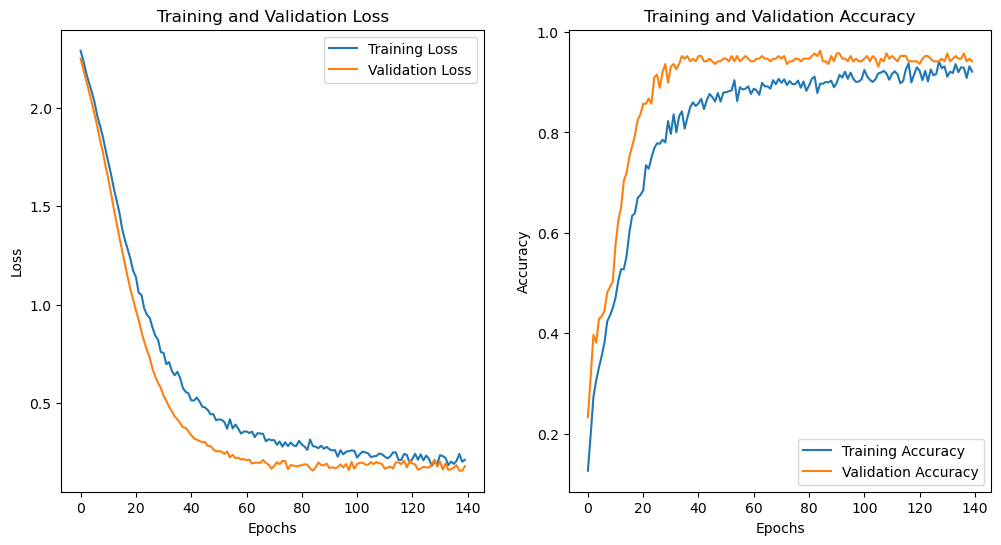

In [216]:
visualize_training_metrics(history)

## Model Evaluation and Testing

In [217]:
test_features, test_masks = test_data

#### Evaluate on the entire dataset

In [218]:
loss, accuracy = sequence_model.evaluate([test_features, test_masks], test_labels, batch_size=32)

print(f"Test Loss: {loss :.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9396 - loss: 0.2751 
Test Loss: 0.2763
Test Accuracy: 92.71%


#### Evaluation with single sample

Function to prepare the test video

In [219]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ),dtype="bool" )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, frames_batch in enumerate(frames):
        video_length = frames_batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(frames_batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

Make predictions on a single video

In [220]:
def sequence_prediction(seq_model, frames, true_label):
    frame_features, frame_mask = create_video_mask_and_features(frames)
    probabilities = seq_model.predict([frame_features, frame_mask])[0]
        
    print("\nTop-5 predicted actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  - {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    # Get the top-1 predicted label (highest probability)
    predicted_index = np.argmax(probabilities)
    predicted_label = class_vocab[predicted_index]

    # Convert true_label to index to align with predicted index format
    true_label_index = class_vocab.index(true_label)

    # Prepare y_true and y_pred as binary arrays (1 for correct label, 0 for others)
    y_true = np.zeros(len(class_vocab))
    y_pred = np.zeros(len(class_vocab))
    y_true[true_label_index] = 1
    y_pred[predicted_index] = 1
 
    return y_true, y_pred, predicted_label

Display predicted image as GIF

In [221]:
def display_as_gif(images):
    gif_path = "../../data/animation.gif"
    converted_images = images.astype(np.uint8)
    imageio.mimsave(gif_path, converted_images, duration=100)
    return Image(gif_path)

Choosing a random video to use for prediction

Test video path: /Users/mzitoh/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4/test/HorseRace/v_HorseRace_g15_c03.avi
Label: HorseRace

Test video frames shape:
  - 267 frames
  - 224 pixels (height) x 224 pixels (width)
  - 3 color channels



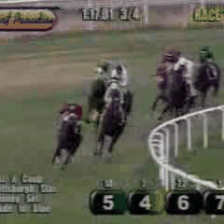

In [222]:
random_index = np.random.randint(len(test_df))

# Get the test video path
test_video = test_df["video_path"].values[random_index]

# Get the true label of the test video
true_label_index = test_labels.tolist()[random_index][0]
true_label = class_vocab[true_label_index]

test_video_frames = load_and_preprocess_video(test_video)

print(f"Test video path: {test_video}")
print(f"Label: {true_label}")

print(f"""
Test video frames shape:
  - {test_video_frames.shape[0]} frames
  - {test_video_frames.shape[1]} pixels (height) x {test_video_frames.shape[2]} pixels (width)
  - {test_video_frames.shape[3]} color channels
""")

display_as_gif(test_video_frames[:MAX_SEQ_LENGTH])

Run the prediction on the test video

In [223]:
y_true, y_pred, predicted_label = sequence_prediction(sequence_model, test_video_frames, true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

Top-5 predicted actions:
  - HorseRace: 99.63%
  - Biking:  0.28%
  - Basketball:  0.05%
  - Punch:  0.02%
  - Surfing:  0.02%


In [224]:
print(f"\nTrue label: {true_label}")
print(f"Predicted label: {predicted_label}")

print(f"y_true: {y_true}")
print(f"y_pred: {y_pred}")


True label: HorseRace
Predicted label: HorseRace
y_true: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
y_pred: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


#### Evaluation on the entire test set

Utility to display evaluation Metrics

In [225]:
def display_evaluation_metrics(y_true, y_pred, predictions, target_classes):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Top-1 Accuracy: {accuracy * 100:.2f}%")

    k = 2
    top_k_acc = top_k_accuracy_score(y_true, predictions, k=k)
    print(f"Top-{k} Accuracy: {top_k_acc * 100:.2f}%")

    report = classification_report(y_true, y_pred, target_names=target_classes, zero_division=0)
    print("\nClassification Report:\n", report)

In [226]:
predictions = sequence_model.predict([test_features, test_masks], batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [227]:
display_evaluation_metrics(test_labels, predicted_classes, predictions, class_vocab)

Top-1 Accuracy: 92.71%
Top-2 Accuracy: 97.40%

Classification Report:
               precision    recall  f1-score   support

   SkyDiving       1.00      0.93      0.96        14
      Biking       1.00      0.82      0.90        17
   HorseRace       0.76      0.81      0.79        16
     Surfing       1.00      1.00      1.00        16
 TennisSwing       0.95      1.00      0.98        21
       Punch       1.00      0.95      0.97        20
  Basketball       0.89      0.91      0.90        34
    JumpRope       0.89      0.94      0.92        18
     Archery       0.90      1.00      0.95        19
      Skiing       0.94      0.88      0.91        17

    accuracy                           0.93       192
   macro avg       0.93      0.93      0.93       192
weighted avg       0.93      0.93      0.93       192



In [228]:
def display_confusion_matrix(y_true, y_pred, target_classes, show_plot=False):
    conf_matrix = confusion_matrix(y_true, y_pred)

    if show_plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            conf_matrix,
            fmt="d",
            annot=True,
            cmap="Blues",
            xticklabels=target_classes,
            yticklabels=target_classes,
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
    else:
        print(conf_matrix)

In [229]:
true_labels = np.array(test_labels).flatten()
display_confusion_matrix(true_labels, predicted_classes, class_vocab, show_plot=False)

[[13  0  0  0  0  0  0  0  0  1]
 [ 0 14  2  0  0  0  0  0  1  0]
 [ 0  0 13  0  0  0  3  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  1  0]
 [ 0  0  1  0  1  0 31  1  0  0]
 [ 0  0  0  0  0  0  1 17  0  0]
 [ 0  0  0  0  0  0  0  0 19  0]
 [ 0  0  1  0  0  0  0  1  0 15]]


## References

> Minimal Implementations, "Hyperparameter Tuning Analysis," WandB. [Online]. Available: https://wandb.ai/minimal-implementations/vivit/reports/Hyperparameter-Tuning-Analysis--VmlldzoxNDEwNzcx